Welcome DataHacker!
 
Congratulations on your new job! This time you are helping out Unicorn Investors with your data hacking skills. They are considering making an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. You are provided with traffic data of JetRail since inception in the test file.

Evaluation Metric:
Root Mean Squre Error (RMSE) is the evaluation metric for this contest

Load libraries

In [425]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

Import csv file

In [426]:
# load datasets
train = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/Jet-Rail-TS/main/Train_SU63ISt%20-%20Train_SU63ISt.csv',index_col=[1], parse_dates=[1])
test = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/Jet-Rail-TS/main/Test_0qrQsBZ%20-%20Test_0qrQsBZ.csv',index_col=[1], parse_dates=[1])
sample = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/Jet-Rail-TS/main/sample_submission_LSeus50%20-%20sample_submission_LSeus50.csv')


In [427]:
train

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2
...,...,...
2014-09-25 19:00:00,18283,868
2014-09-25 20:00:00,18284,732
2014-09-25 21:00:00,18285,702


In [428]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18288 entries, 2012-08-25 00:00:00 to 2014-09-25 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      18288 non-null  int64
 1   Count   18288 non-null  int64
dtypes: int64(2)
memory usage: 428.6 KB


In [429]:
test

,ID
Datetime,
2014-09-26 00:00:00,18288
2014-09-26 01:00:00,18289
2014-09-26 02:00:00,18290
2014-09-26 03:00:00,18291
2014-09-26 04:00:00,18292
...,...
2015-04-26 19:00:00,23395
2015-04-26 20:00:00,23396
2015-04-26 21:00:00,23397


In [430]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5112 entries, 2014-09-26 00:00:00 to 2015-04-26 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      5112 non-null   int64
dtypes: int64(1)
memory usage: 79.9 KB


In [431]:
sample

,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0
...,...,...
5107,23395,0
5108,23396,0
5109,23397,0
5110,23398,0


Assign colours for palette

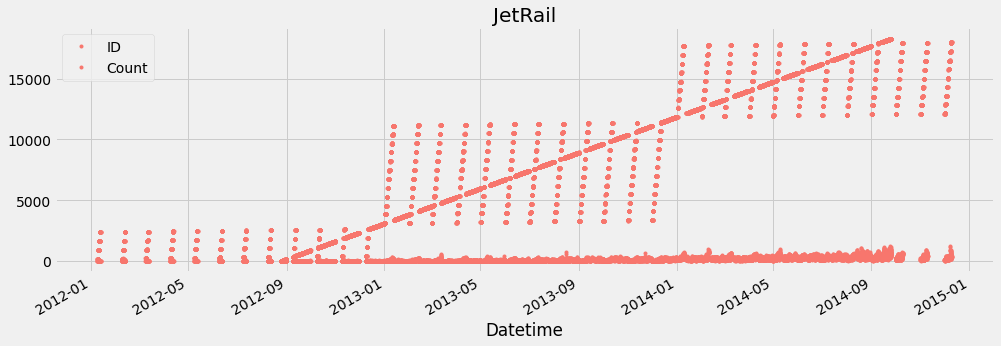

In [432]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
train.plot(style='.', figsize=(15,5), color=color_pal[0], title='JetRail')
plt.show()

Visualise time series

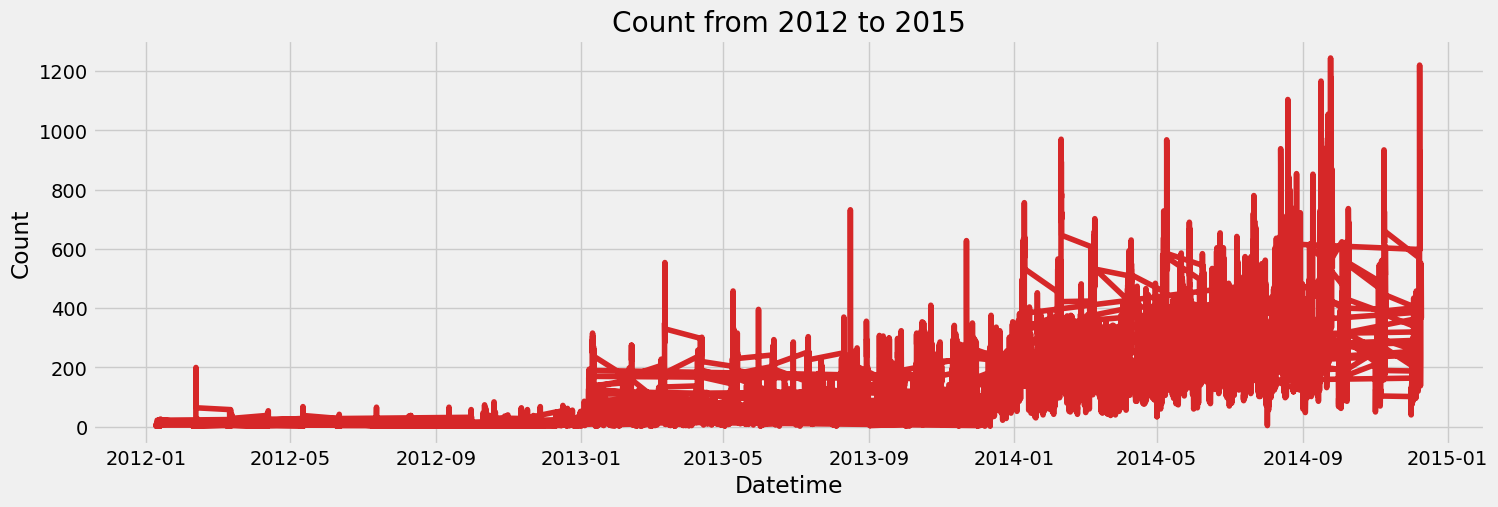

In [433]:
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/Jet-Rail-TS/main/Train_SU63ISt%20-%20Train_SU63ISt.csv', parse_dates=['Datetime'], index_col=['Datetime'])

def plot_df(train, x, y, title="", xlabel='Datetime', ylabel='Count', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(train, x=df.index, y=train['Count'], title='Count from 2012 to 2015') 

Show both sides of axis

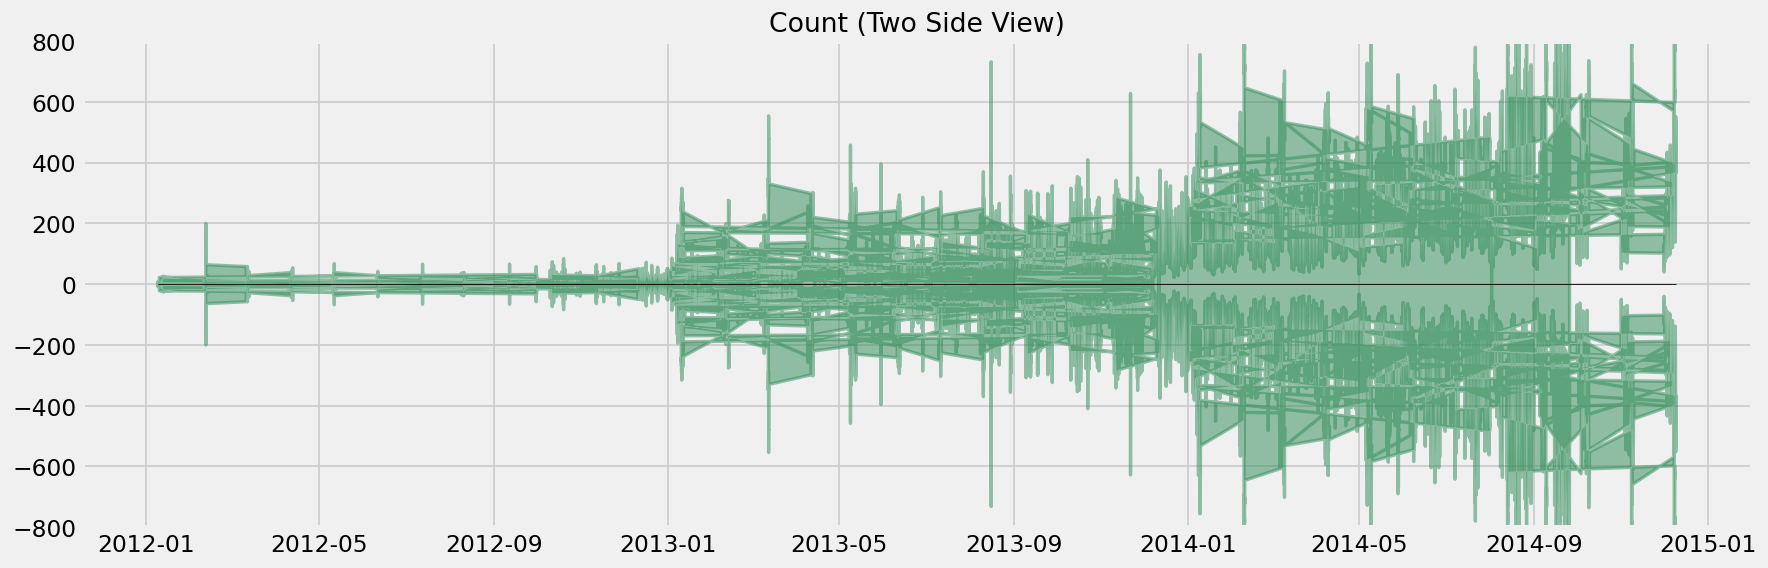

In [434]:
x = df.index.values
y1 = df['Count'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-800, 800)
plt.title('Count (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.index), xmax=np.max(df.index), linewidth=.5)
plt.show()

EDA

In [435]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(train, label='Count')

features_and_target = pd.concat([X, y], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [436]:
# See our features and target
features_and_target

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Count
Datetime,,,,,,,,,
2012-08-25 00:00:00,0,5,3,8,2012,238,25,34,8
2012-08-25 01:00:00,1,5,3,8,2012,238,25,34,2
2012-08-25 02:00:00,2,5,3,8,2012,238,25,34,6
2012-08-25 03:00:00,3,5,3,8,2012,238,25,34,2
2012-08-25 04:00:00,4,5,3,8,2012,238,25,34,2
...,...,...,...,...,...,...,...,...,...
2014-09-25 19:00:00,19,3,3,9,2014,268,25,39,868
2014-09-25 20:00:00,20,3,3,9,2014,268,25,39,732
2014-09-25 21:00:00,21,3,3,9,2014,268,25,39,702


Plotting features to see trends

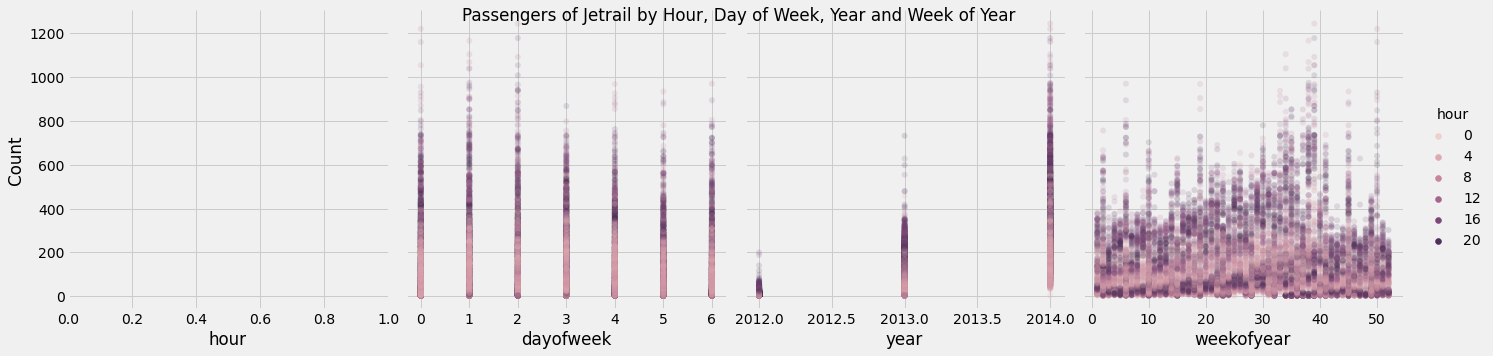

In [437]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='Count',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Passengers of Jetrail by Hour, Day of Week, Year and Week of Year')
plt.show()

Train / Test split

In [438]:
ID_train = train.ID
ID_test = test.ID

train.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [439]:
split_date = '09-01-2014'
j_train = train.loc[train.index <= split_date].copy()
j_val = train.loc[train.index > split_date].copy()
j_test = test.copy()

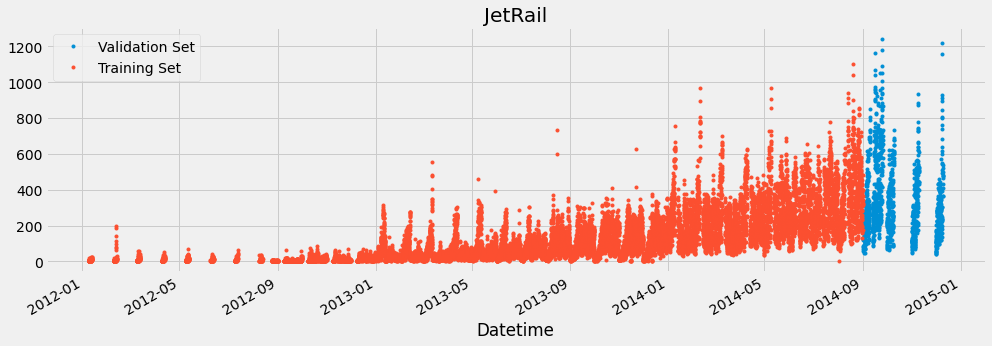

In [440]:
# Plot train and val so you can see where we have split
j_val \
    .rename(columns={'Count': 'Validation Set'}) \
    .join(j_train.rename(columns={'Count': 'Training Set'}),
          how='outer') \
    .plot(figsize=(15,5), title='JetRail', style='.')
plt.show()

Simple Prophet model

In [441]:
# Format data for prophet model using ds and y
j_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'Count':'y'})

,ds,y
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2
...,...,...
17108,2014-08-09 19:00:00,636
17109,2014-08-09 20:00:00,608
17110,2014-08-09 21:00:00,560
17111,2014-08-09 22:00:00,508


In [442]:
# Format data for prophet model using ds and y
j_test.reset_index() \
    .rename(columns={'Datetime':'ds'})

,ds
0,2014-09-26 00:00:00
1,2014-09-26 01:00:00
2,2014-09-26 02:00:00
3,2014-09-26 03:00:00
4,2014-09-26 04:00:00
...,...
5107,2015-04-26 19:00:00
5108,2015-04-26 20:00:00
5109,2015-04-26 21:00:00
5110,2015-04-26 22:00:00


In [443]:
# Setup and train model and fit
model = Prophet()
model.fit(j_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'Count':'y'}))

Predict on validation set

In [444]:
# Predict on validation set with model
j_val_fcst = model.predict(df=j_val.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))
j_val_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-09-01 01:00:00,384.985903,267.463606,471.274018,384.985903,384.985903,-14.362735,-14.362735,-14.362735,-14.281840,-14.281840,-14.281840,-10.190773,-10.190773,-10.190773,10.109879,10.109879,10.109879,0.0,0.0,0.0,370.623168
1,2014-09-01 02:00:00,385.029907,260.420334,448.746132,385.029907,385.029907,-33.117622,-33.117622,-33.117622,-34.694276,-34.694276,-34.694276,-8.485096,-8.485096,-8.485096,10.061750,10.061750,10.061750,0.0,0.0,0.0,351.912285
2,2014-09-01 03:00:00,385.073911,233.913856,439.631492,385.073911,385.073911,-47.561902,-47.561902,-47.561902,-50.794079,-50.794079,-50.794079,-6.781160,-6.781160,-6.781160,10.013338,10.013338,10.013338,0.0,0.0,0.0,337.512009
3,2014-09-01 04:00:00,385.117915,233.854678,430.524404,385.117915,385.117915,-56.152422,-56.152422,-56.152422,-61.030066,-61.030066,-61.030066,-5.087000,-5.087000,-5.087000,9.964644,9.964644,9.964644,0.0,0.0,0.0,328.965493
4,2014-09-01 05:00:00,385.161919,224.216741,412.789904,385.161919,385.161919,-59.744418,-59.744418,-59.744418,-66.249631,-66.249631,-66.249631,-3.410457,-3.410457,-3.410457,9.915670,9.915670,9.915670,0.0,0.0,0.0,325.417501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,2014-12-09 19:00:00,490.331718,410.065685,601.707149,483.496193,497.236093,15.941436,15.941436,15.941436,35.074716,35.074716,35.074716,15.593498,15.593498,15.593498,-34.726778,-34.726778,-34.726778,0.0,0.0,0.0,506.273154
1171,2014-12-09 20:00:00,490.375722,411.954676,596.084483,483.537277,497.284921,12.627192,12.627192,12.627192,32.070708,32.070708,32.070708,15.267627,15.267627,15.267627,-34.711142,-34.711142,-34.711142,0.0,0.0,0.0,503.002914
1172,2014-12-09 21:00:00,490.419726,398.057236,599.284636,483.578362,497.333749,10.003378,10.003378,10.003378,29.750328,29.750328,29.750328,14.947878,14.947878,14.947878,-34.694829,-34.694829,-34.694829,0.0,0.0,0.0,500.423104
1173,2014-12-09 22:00:00,490.463730,402.237845,599.737508,483.619447,497.382577,6.987586,6.987586,6.987586,27.028371,27.028371,27.028371,14.637051,14.637051,14.637051,-34.677836,-34.677836,-34.677836,0.0,0.0,0.0,497.451316


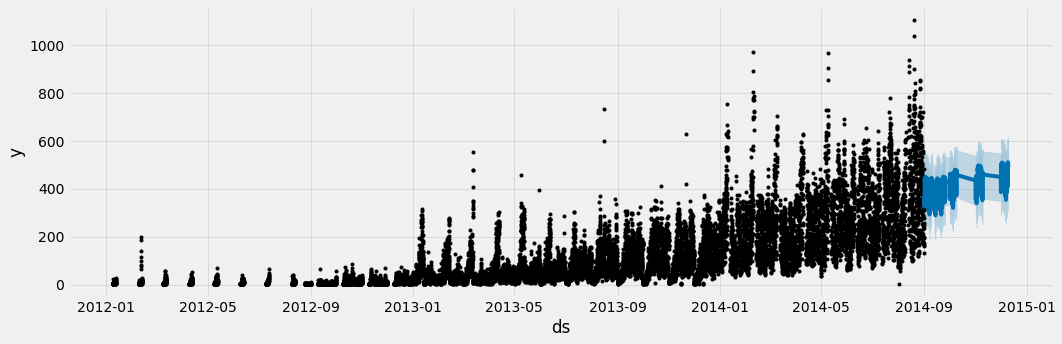

In [445]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(j_val_fcst,
                 ax=ax)
plt.show()

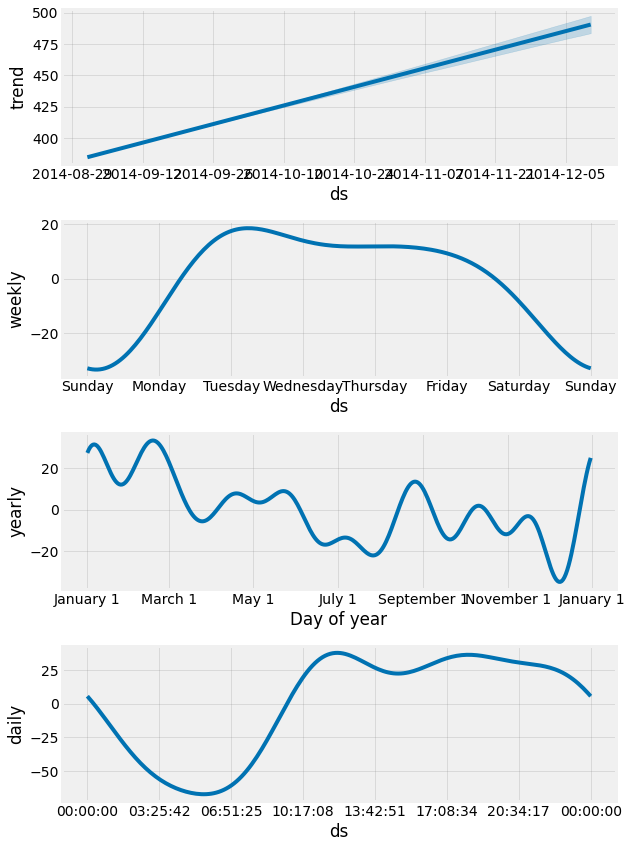

In [446]:
# Plot the components of the model
fig = model.plot_components(j_val_fcst)

Compare forecast to actuals

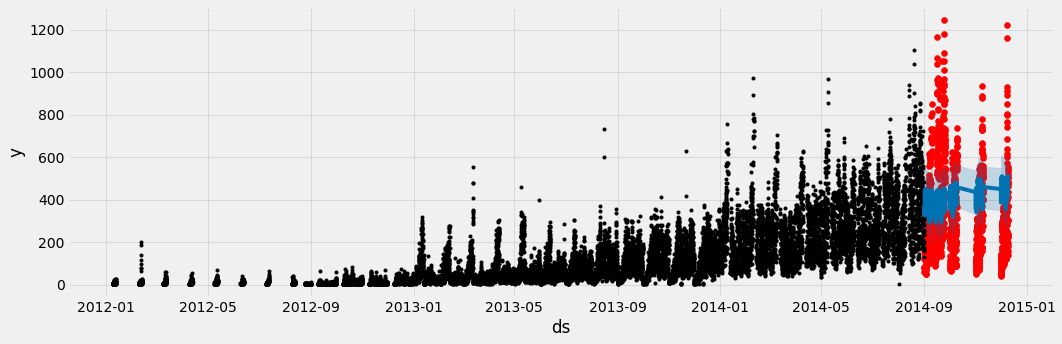

In [447]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(j_val.index, j_val['Count'], color='r')
fig = model.plot(j_val_fcst, ax=ax)

Error metrics

In [448]:
mean_squared_error(y_true=j_val['Count'],
                   y_pred=j_val_fcst['yhat'])

39800.876638109024

In [449]:
mean_absolute_error(y_true=j_val['Count'],
                   y_pred=j_val_fcst['yhat'])

167.80142554584208

In [450]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=j_val['Count'],
                   y_pred=j_val_fcst['yhat'])

83.86572235276796

Compare actual values against predicted values

In [451]:
y_true = j_val.Count.values
y_true

array([160, 122,  84, ..., 702, 580, 534])

In [452]:
y_hat = j_val_fcst.yhat.astype(int)
y_hat

0       370
1       351
2       337
3       328
4       325
       ... 
1170    506
1171    503
1172    500
1173    497
1174    490
Name: yhat, Length: 1175, dtype: int64

In [453]:
dfval=pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})
dfval.reset_index(drop=True, inplace=True)
dfval

,Actual,Predicted
0,160,370
1,122,351
2,84,337
3,60,328
4,78,325
...,...,...
1170,868,506
1171,732,503
1172,702,500
1173,580,497


Predicting on test set

In [454]:
# Predict on test set with model
j_test_fcst = model.predict(df=j_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))
j_test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-10 00:00:00,167.626234,114.946276,307.709199,167.626234,167.626234,44.467963,44.467963,44.467963,5.637257,5.637257,5.637257,9.390511,9.390511,9.390511,29.440195,29.440195,29.440195,0.0,0.0,0.0,212.094197
1,2014-01-10 01:00:00,167.653975,95.685374,288.409723,167.653975,167.653975,24.180059,24.180059,24.180059,-14.281840,-14.281840,-14.281840,9.064894,9.064894,9.064894,29.397006,29.397006,29.397006,0.0,0.0,0.0,191.834034
2,2014-01-10 02:00:00,167.681715,72.595671,271.829508,167.681715,167.681715,3.371414,3.371414,3.371414,-34.694276,-34.694276,-34.694276,8.712226,8.712226,8.712226,29.353464,29.353464,29.353464,0.0,0.0,0.0,171.053129
3,2014-01-10 03:00:00,167.709455,54.867118,247.823551,167.709455,167.709455,-13.153465,-13.153465,-13.153465,-50.794079,-50.794079,-50.794079,8.331042,8.331042,8.331042,29.309573,29.309573,29.309573,0.0,0.0,0.0,154.555991
4,2014-01-10 04:00:00,167.737196,42.407440,246.536682,167.737196,167.737196,-23.844884,-23.844884,-23.844884,-61.030066,-61.030066,-61.030066,7.919847,7.919847,7.919847,29.265335,29.265335,29.265335,0.0,0.0,0.0,143.892312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5107,2015-12-04 19:00:00,870.527142,742.455286,988.327113,799.300294,940.361371,0.689707,0.689707,0.689707,35.074716,35.074716,35.074716,-2.702201,-2.702201,-2.702201,-31.682807,-31.682807,-31.682807,0.0,0.0,0.0,871.216849
5108,2015-12-04 20:00:00,870.571146,736.749462,983.683887,799.334979,940.414629,-3.405117,-3.405117,-3.405117,32.070708,32.070708,32.070708,-3.734348,-3.734348,-3.734348,-31.741477,-31.741477,-31.741477,0.0,0.0,0.0,867.166029
5109,2015-12-04 21:00:00,870.615151,740.901253,990.695007,799.369664,940.467887,-6.853572,-6.853572,-6.853572,29.750328,29.750328,29.750328,-4.804212,-4.804212,-4.804212,-31.799689,-31.799689,-31.799689,0.0,0.0,0.0,863.761579
5110,2015-12-04 22:00:00,870.659155,744.900007,977.802706,799.404349,940.521146,-10.738902,-10.738902,-10.738902,27.028371,27.028371,27.028371,-5.909833,-5.909833,-5.909833,-31.857440,-31.857440,-31.857440,0.0,0.0,0.0,859.920253


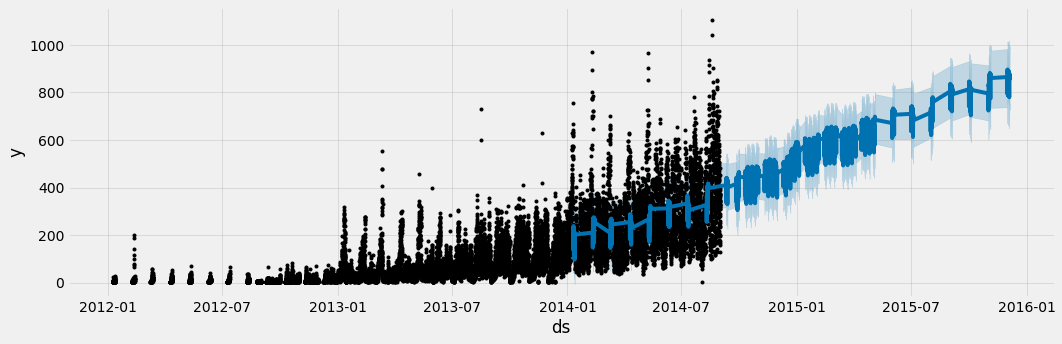

In [455]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(j_test_fcst,
                 ax=ax)
plt.show()

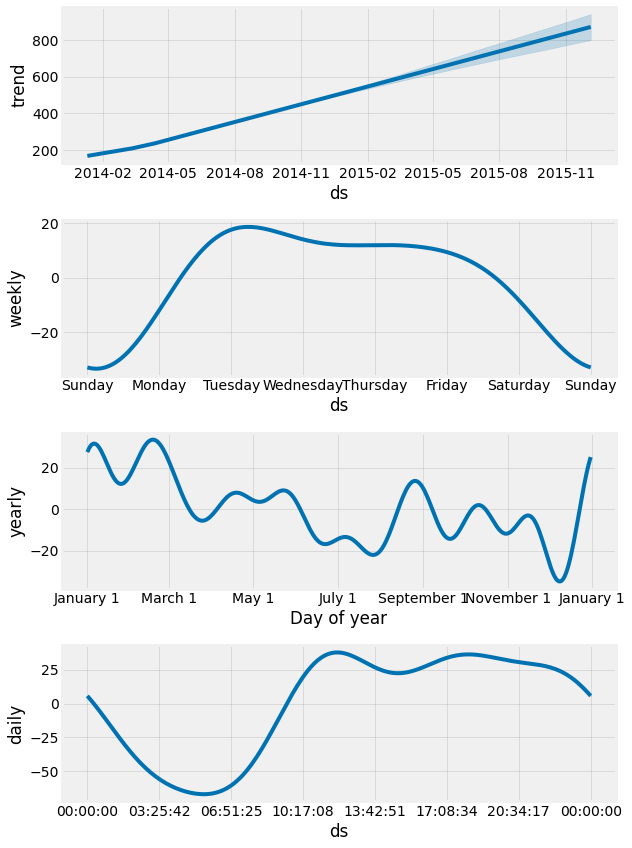

In [456]:
# Plot the components of the model
fig = model.plot_components(j_test_fcst)

Prepare submission

In [461]:
submission = pd.DataFrame({'ID': ID_test.values, 'Count': j_test_fcst.yhat.values})

In [462]:
# Converting the final submission to csv format 
submission.to_csv('submission.csv',index=False)
submission = pd.read_csv("submission.csv")
submission

,ID,Count
0,18288,212.094197
1,18289,191.834034
2,18290,171.053129
3,18291,154.555991
4,18292,143.892312
...,...,...
5107,23395,871.216849
5108,23396,867.166029
5109,23397,863.761579
5110,23398,859.920253
